This is based on the "Examining Environmental Justice through Open Source, Cloud-Native Tools" notebook from Carl Boettiger. Please follow [Carl's notebook](https://boettiger-lab.github.io/nasa-topst-env-justice/contents/intro.html) for the background. This tutorial just focuses on the code.

# Set up

You install a few things that are not on this JHub.

In [ ]:
# It is bad to install via pip into a conda environment. I know this
# Remove the commenting and run
# ! pip install odc-stac stac
# ! pip install geopolars

In [7]:
import odc.stac
import rioxarray
from pystac_client import Client
import geopandas as gpd
from rasterstats import zonal_stats 

import dask.distributed
client = dask.distributed.Client()
odc.stac.configure_rio(cloud_defaults=True, client=client)

## Data discovery

Here we use a [STAC](https://stacspec.org/en) Catalog API to recover a list of candidate data. 
This example searches for images in a lon-lat bounding box from a collection of Cloud-Optimized-GeoTIFF (COG) images taken by Sentinel2 satellite mission. This function will not download any imagery, it merely gives us a list of metadata about available images.

In [8]:
box = [-122.51, 37.71, -122.36, 37.81]
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2022-06-01/2022-08-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)


We pass this list of images to a high-level utilty (`gdalcubes`) that will do all of the heavy lifting:

* subsetting by date
* subsetting by bounding box
* aggregating by time `P1D`
* reproject into the desired coordinate system
* resampling to a desired spatial resolution


In [9]:
data = odc.stac.load(
    items,
    crs="EPSG:4326",
    bands=["nir08", "red"],
    resolution=0.0001,
    bbox=box
)

Calculate NDVI, a widely used measure of greenness that can be used to determine tree cover. 

In [10]:
red = data.red
nir = data.nir08

ndvi = (((nir - red) / (red + nir)).
        resample(time="MS").
        median("time", keep_attrs=True).
        compute()
)

# mask out bad pixels
ndvi = ndvi.where(ndvi <= 1)

Plot the result.  The long rectangle of Golden Gate Park is clearly visible in the North-West.

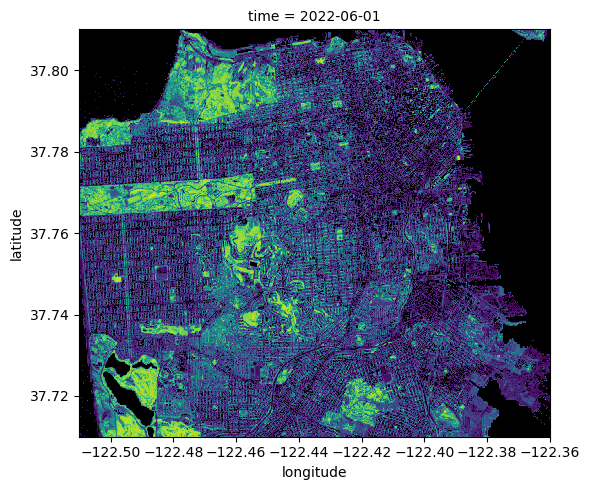

In [12]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ndvi.plot.imshow(row="time", cmap=cmap, add_colorbar=False, size=5)

Add the 1937 "red-lining" zones from the [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining) project.  The red-lined zones are spatial vectors. 

In [24]:
ndvi.rio.to_raster(raster_path="ndvi.tif", driver="COG")
sf_url = "/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/citiesData/CASanFrancisco1937/geojson.json"
mean_ndvi = zonal_stats(sf_url, "ndvi.tif", stats="mean")

Now we can plot

<Axes: >

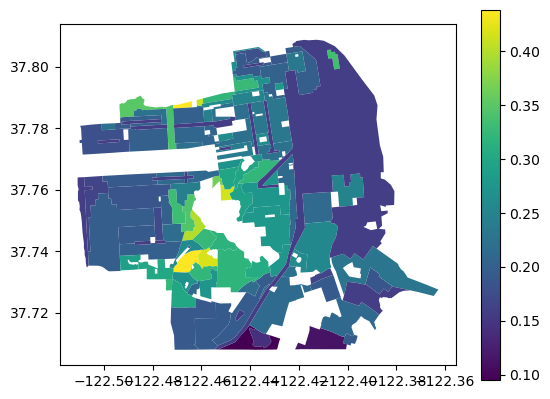

In [25]:
sf = gpd.read_file(sf_url)
sf["ndvi"] = [x["mean"] for x in mean_ndvi ]
sf.plot(column="ndvi", legend=True)

Compute the mean current greenness by 1937 zone.

In [30]:
import geopolars as gpl
import polars as pl

(gpl.
  from_geopandas(sf).
  group_by("grade").
  agg(pl.col("ndvi").mean()).
  sort("grade")
)

grade,ndvi
str,f64
null,0.157821
"""A""",0.338723
"""B""",0.247344
"""C""",0.231182
"""D""",0.225696
